In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from scipy.cluster import hierarchy
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

from statsmodels.stats.outliers_influence import variance_inflation_factor
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold

import custom_map

In [92]:
import importlib

importlib.reload(custom_map)

<module 'custom_map' from '/Users/dominikmika/PycharmProjects/Ridge-Hill-Climbing/src/custom_map.py'>

# Data cleaning

In [93]:
data = pd.read_csv("../dataset/train.csv")
data.info()

target = "Heart Disease"

<class 'pandas.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thallium                 630000 non-null  int64  
 14  Heart Disease  

In [94]:
data.drop('id', axis=1, inplace=True)

data['Heart Disease'] = np.where(data['Heart Disease'] == 'Presence', 1, 0)

In [95]:
binary_cols = data.columns[data.nunique() == 2]
print("Binary features: ", binary_cols)

categorical_cols = data.columns[(data.nunique() <= 10) & (data.nunique() > 2)]
print("Categorical features: ", categorical_cols)

data.nunique()
print("Number of unique values per column:\n", data.nunique())

numerical_cols = list(set(data.columns).difference(binary_cols, categorical_cols))

numerical_features = pd.concat([data[numerical_cols], data[target]], axis=1)
binary_features = data[binary_cols]
categorical_features = pd.concat([data[categorical_cols], data[target]], axis=1)
categorical_binary_features = pd.concat([data[categorical_cols], data[binary_cols]], axis=1)
numerical_binary_features = pd.concat([data[numerical_cols], data[binary_cols]], axis=1)

Binary features:  Index(['Sex', 'FBS over 120', 'Exercise angina', 'Heart Disease'], dtype='str')
Categorical features:  Index(['Chest pain type', 'EKG results', 'Slope of ST',
       'Number of vessels fluro', 'Thallium'],
      dtype='str')
Number of unique values per column:
 Age                         42
Sex                          2
Chest pain type              4
BP                          66
Cholesterol                150
FBS over 120                 2
EKG results                  3
Max HR                      93
Exercise angina              2
ST depression               66
Slope of ST                  3
Number of vessels fluro      4
Thallium                     3
Heart Disease                2
dtype: int64


# EDA

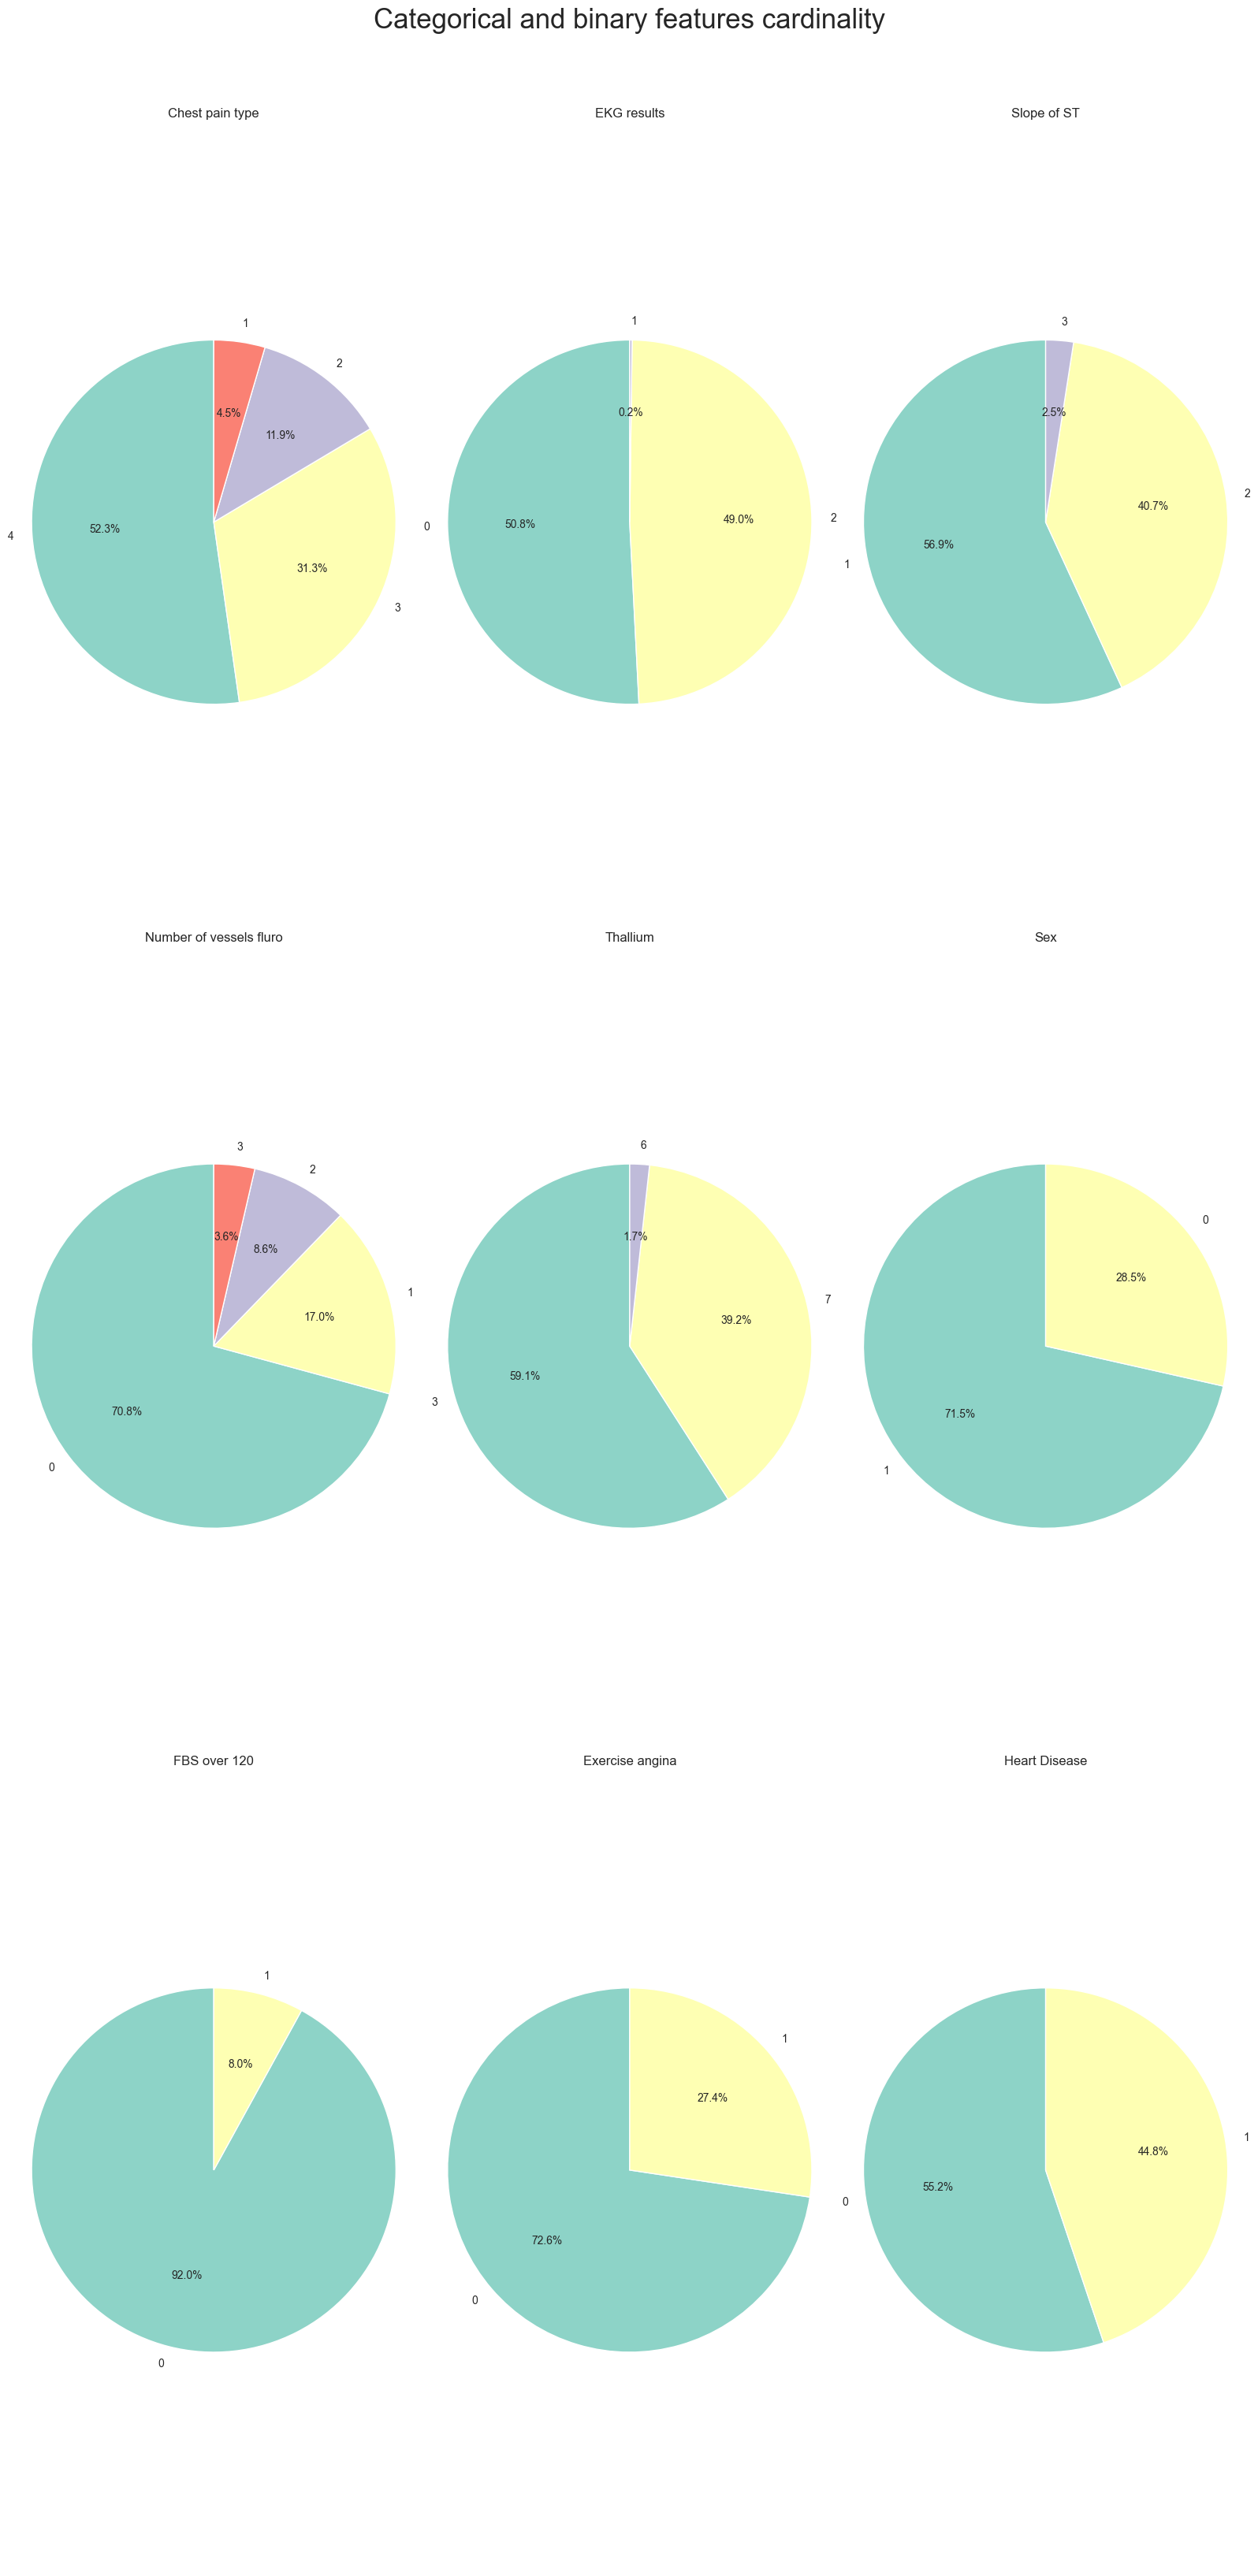

In [96]:
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 32))
axes = axes.flat

for ax, col in zip(axes, categorical_binary_features):
    sizes = data[col].value_counts()
    labels = sizes.index.astype(str)

    ax.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
    ax.set_title(col)
    ax.axis("equal")

fig.suptitle("Categorical and binary features cardinality", fontsize=25, y=1.02)
plt.tight_layout()
plt.show()

In [102]:
chi_results = {}

for col in categorical_binary_features:
    table = pd.crosstab(data[col], data[target])
    chi2, p, dof, ex = chi2_contingency(table)
    chi_results[col] = p

for feature, p_value in chi_results.items():
    print(f"{feature:30} p = {p_value:.6f}")

Chest pain type                → p = 0.000000
EKG results                    → p = 0.000000
Slope of ST                    → p = 0.000000
Number of vessels fluro        → p = 0.000000
Thallium                       → p = 0.000000
Sex                            → p = 0.000000
FBS over 120                   → p = 0.000000
Exercise angina                → p = 0.000000
Heart Disease                  → p = 0.000000


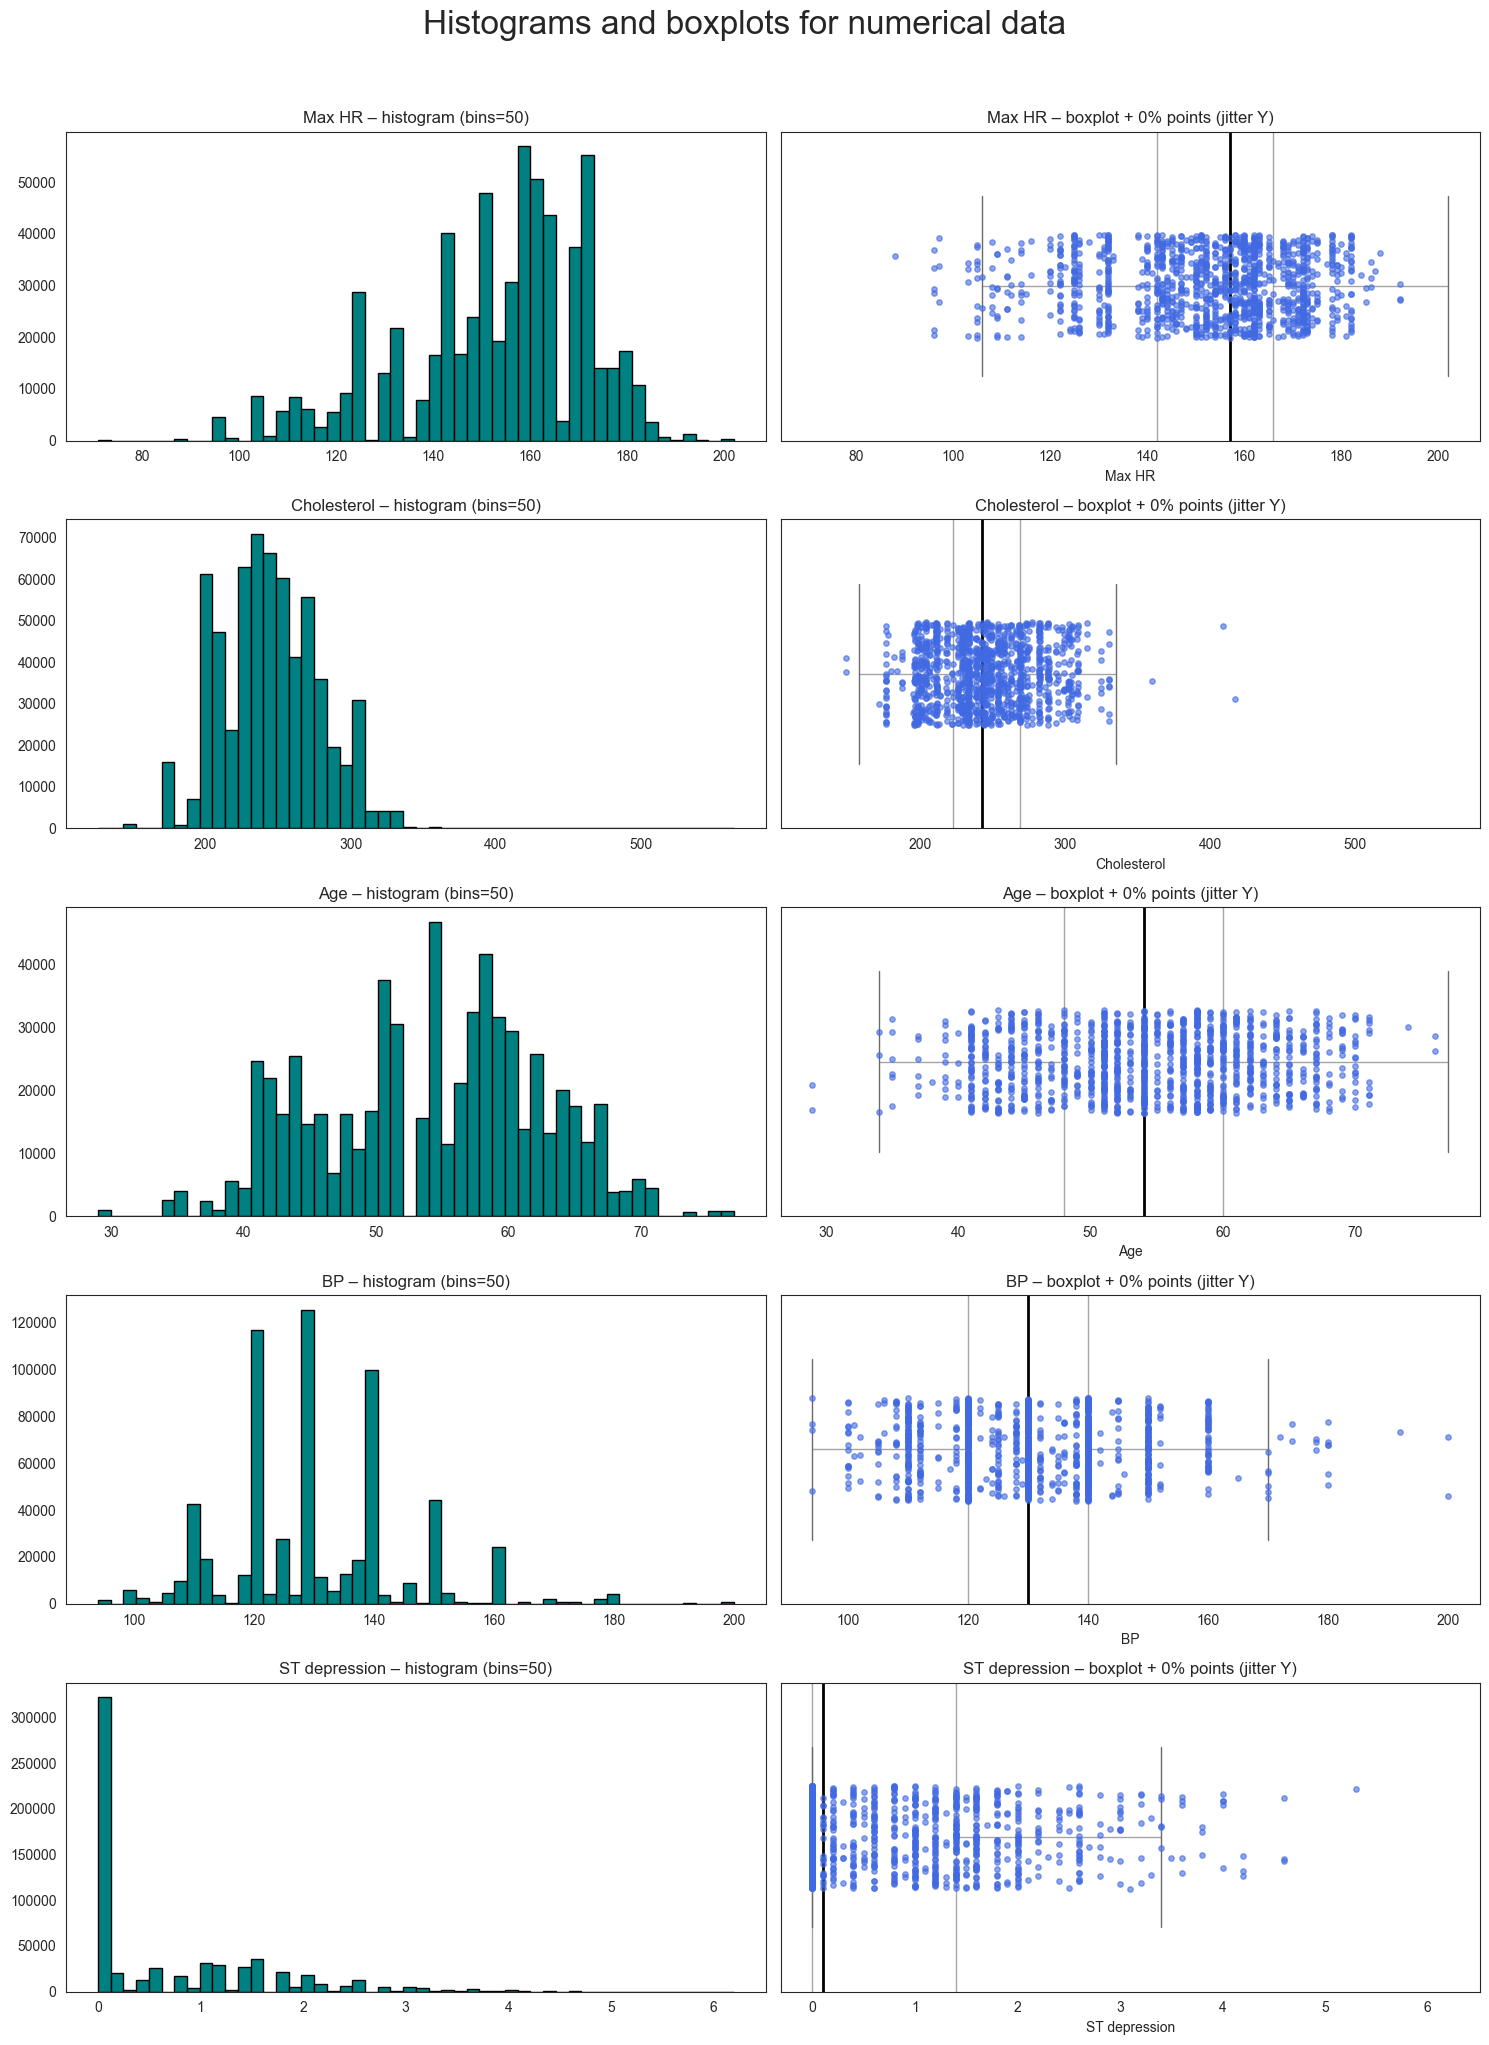

In [98]:
def freedman_diaconis_bins(x):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = len(x)

    if n < 2:
        return 1

    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25

    if iqr == 0:
        return int(np.ceil(np.log2(n) + 1))   # fallback: Sturges

    h = 2.64 * iqr / (n ** (1/3))
    bins = int(np.ceil((x.max() - x.min()) / h))

    return max(1, bins)

SAMPLE_FRAC = 0.002
JITTER_Y = 0.05

n_features = len(numerical_cols)
n_rows = n_features

fig, axes = plt.subplots(n_rows, 2, figsize=(15, 4 * n_features))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    x = data[col].dropna()
    bins = 50

    axes[2*i].hist(x, bins=bins, color="teal", edgecolor="black")
    axes[2*i].set_title(f"{col} – histogram (bins={bins})")

    sns.boxplot(
        x=x,
        ax=axes[2*i + 1],
        width=0.35,
        fliersize=0,
        boxprops=dict(facecolor="white", alpha=0.6),
        whiskerprops=dict(alpha=0.6),
        medianprops=dict(color="black", linewidth=2)
    )

    sample = x.sample(frac=SAMPLE_FRAC, random_state=42)

    y_jitter = np.random.uniform(
        low=-JITTER_Y,
        high=JITTER_Y,
        size=len(sample)
    )

    axes[2*i + 1].scatter(
        sample,
        y_jitter,
        color="royalblue",
        alpha=0.6,
        s=15,
        zorder=3
    )

    axes[2*i + 1].set_yticks([])
    axes[2*i + 1].set_ylim(-0.15, 0.15)
    axes[2*i + 1].set_title(
        f"{col} – boxplot + {int(SAMPLE_FRAC*100)}% points (jitter Y)"
    )

plt.suptitle("Histograms and boxplots for numerical data", fontsize=24, y=1.02)
plt.tight_layout()
plt.show()

/Users/dominikmika/PycharmProjects/Ridge-Hill-Climbing/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:1513: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=vector, **plot_kwargs)


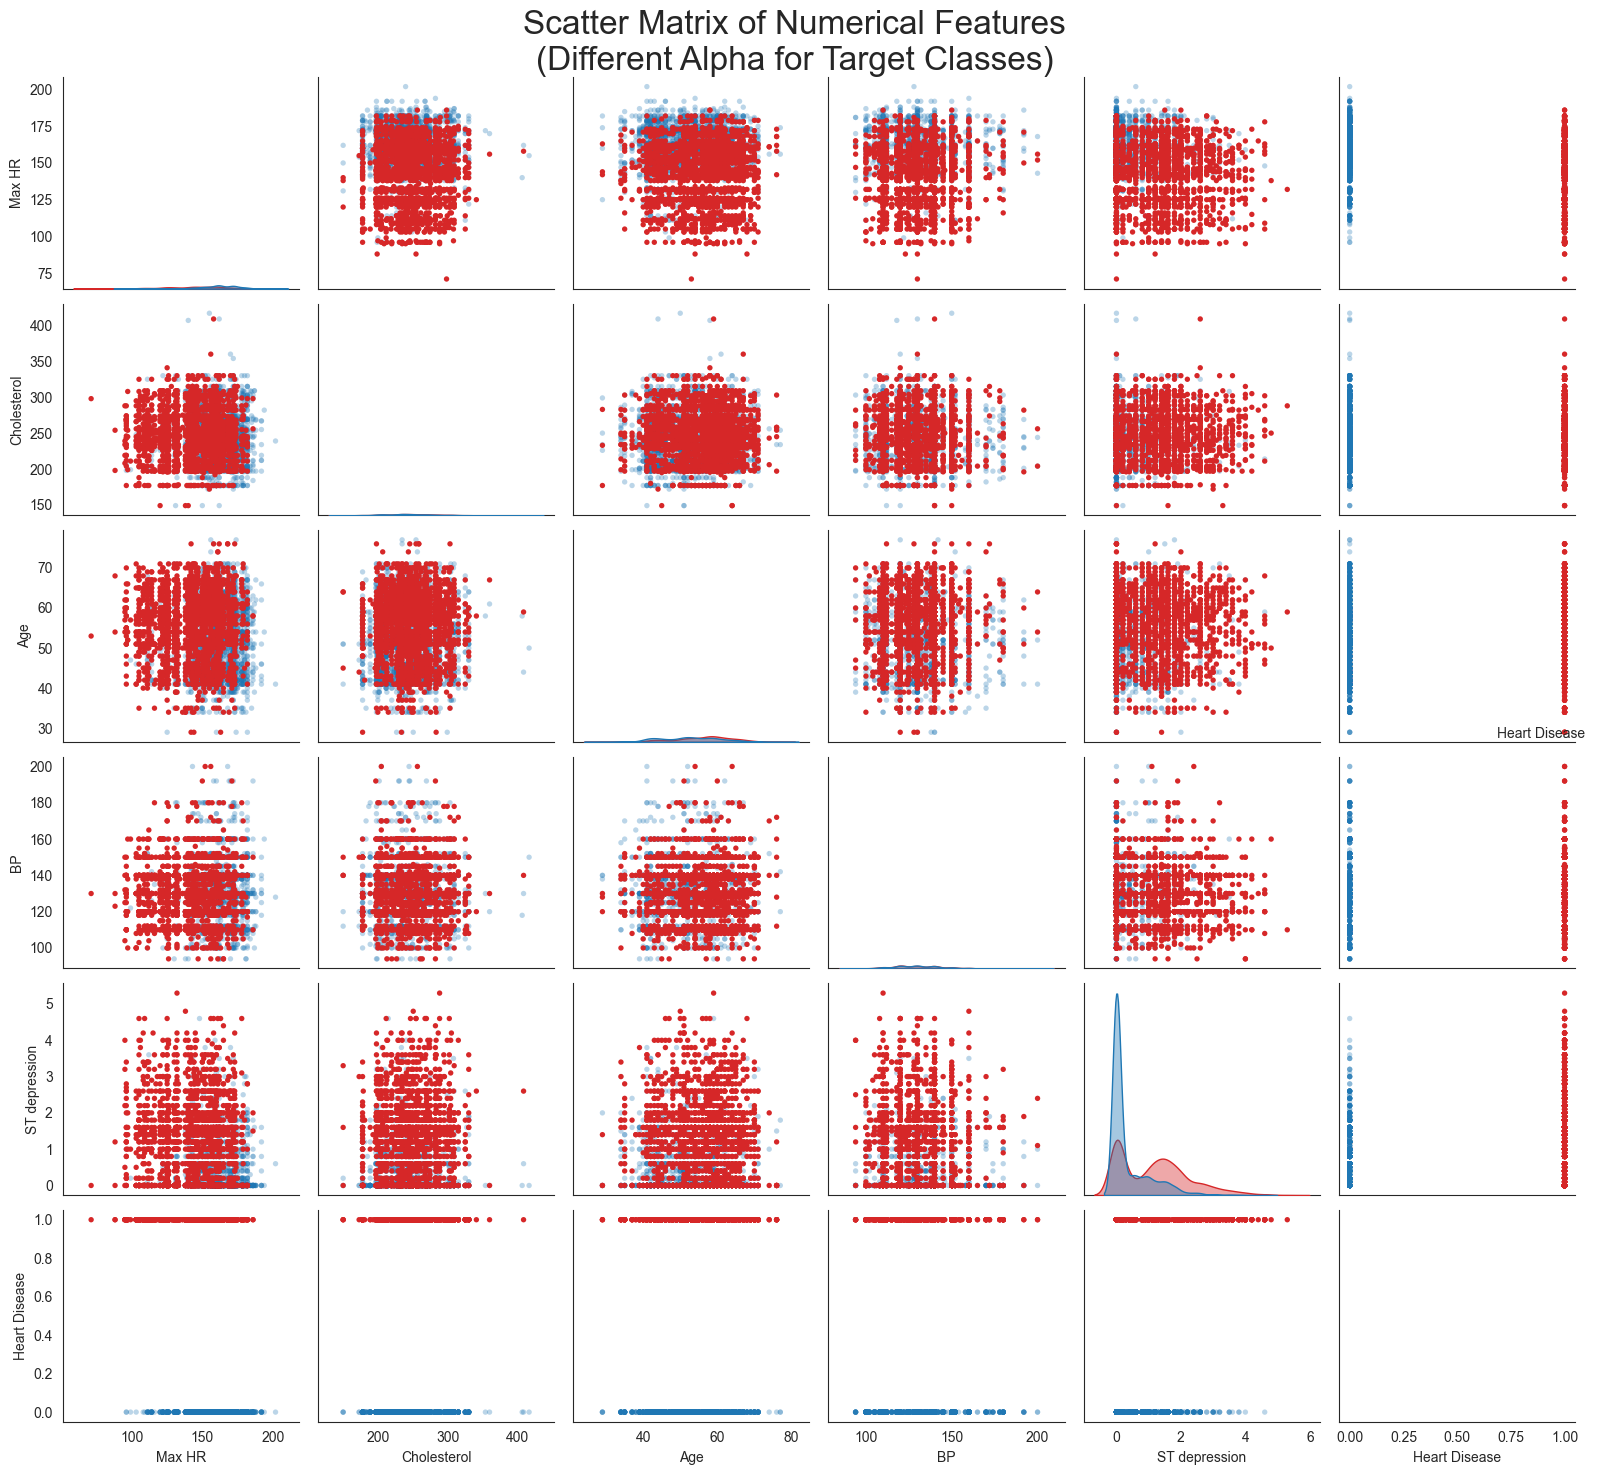

In [107]:
features_for_plot = list(numerical_cols) + [target]
plot_data = data[features_for_plot].sample(5000, random_state=42).copy()

palette = {
    0: "#1f77b4",
    1: "#d62728"
}

alpha_map = {
    0: 0.3,
    1: 1.0
}

def scatter_with_class_alpha(x, y, hue, **kwargs):
    ax = plt.gca()
    for cls in sorted(hue.unique()):
        mask = hue == cls
        ax.scatter(
            x[mask],
            y[mask],
            color=palette[cls],
            alpha=alpha_map[cls],
            s=15,
            edgecolors="none"
        )

sns.set_style("white")

g = sns.PairGrid(
    plot_data,
    vars=numerical_features,
    hue=target,
    palette=palette,
    corner=False
)

g.map_offdiag(scatter_with_class_alpha)

g.map_diag(
    sns.kdeplot,
    fill=True,
    alpha=0.4,
    common_norm=False
)

g.add_legend(title=target)

g.fig.suptitle("Scatter Matrix of Numerical Features\n(Different Alpha for Target Classes)", fontsize=24)

plt.tight_layout()
plt.show()

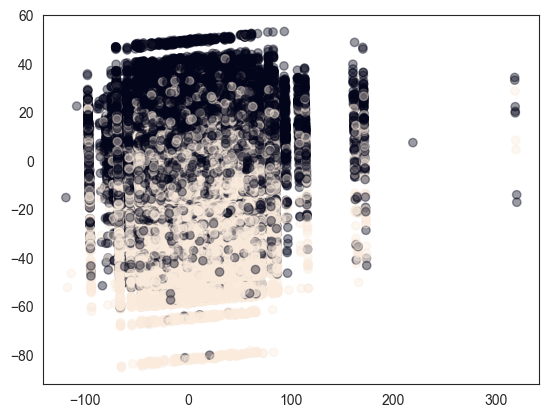

[0.63340848 0.20348424]
Sum: 0.8368927213968249


In [119]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(data[numerical_cols])

plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=data[target],
    alpha=0.4
)
plt.show()

print(pca.explained_variance_ratio_)
print("Sum:", pca.explained_variance_ratio_.sum())

{'name': 'g-bajon', 'alpha_eff': 0.006666666666666667, 'df': 629998.0, 't_crit': 2.713060889671551, 'r_crit': 0.0034181208889113917, 'steps': 2, 'side_left': 127, 'side_right': 127, 'N': 630000.0}


/Users/dominikmika/PycharmProjects/Ridge-Hill-Climbing/src/custom_map.py:37: UserWarning: Overwriting the cmap 'g-bajon' that was already in the registry.
  mpl.colormaps.register(my_cmap, force=True)


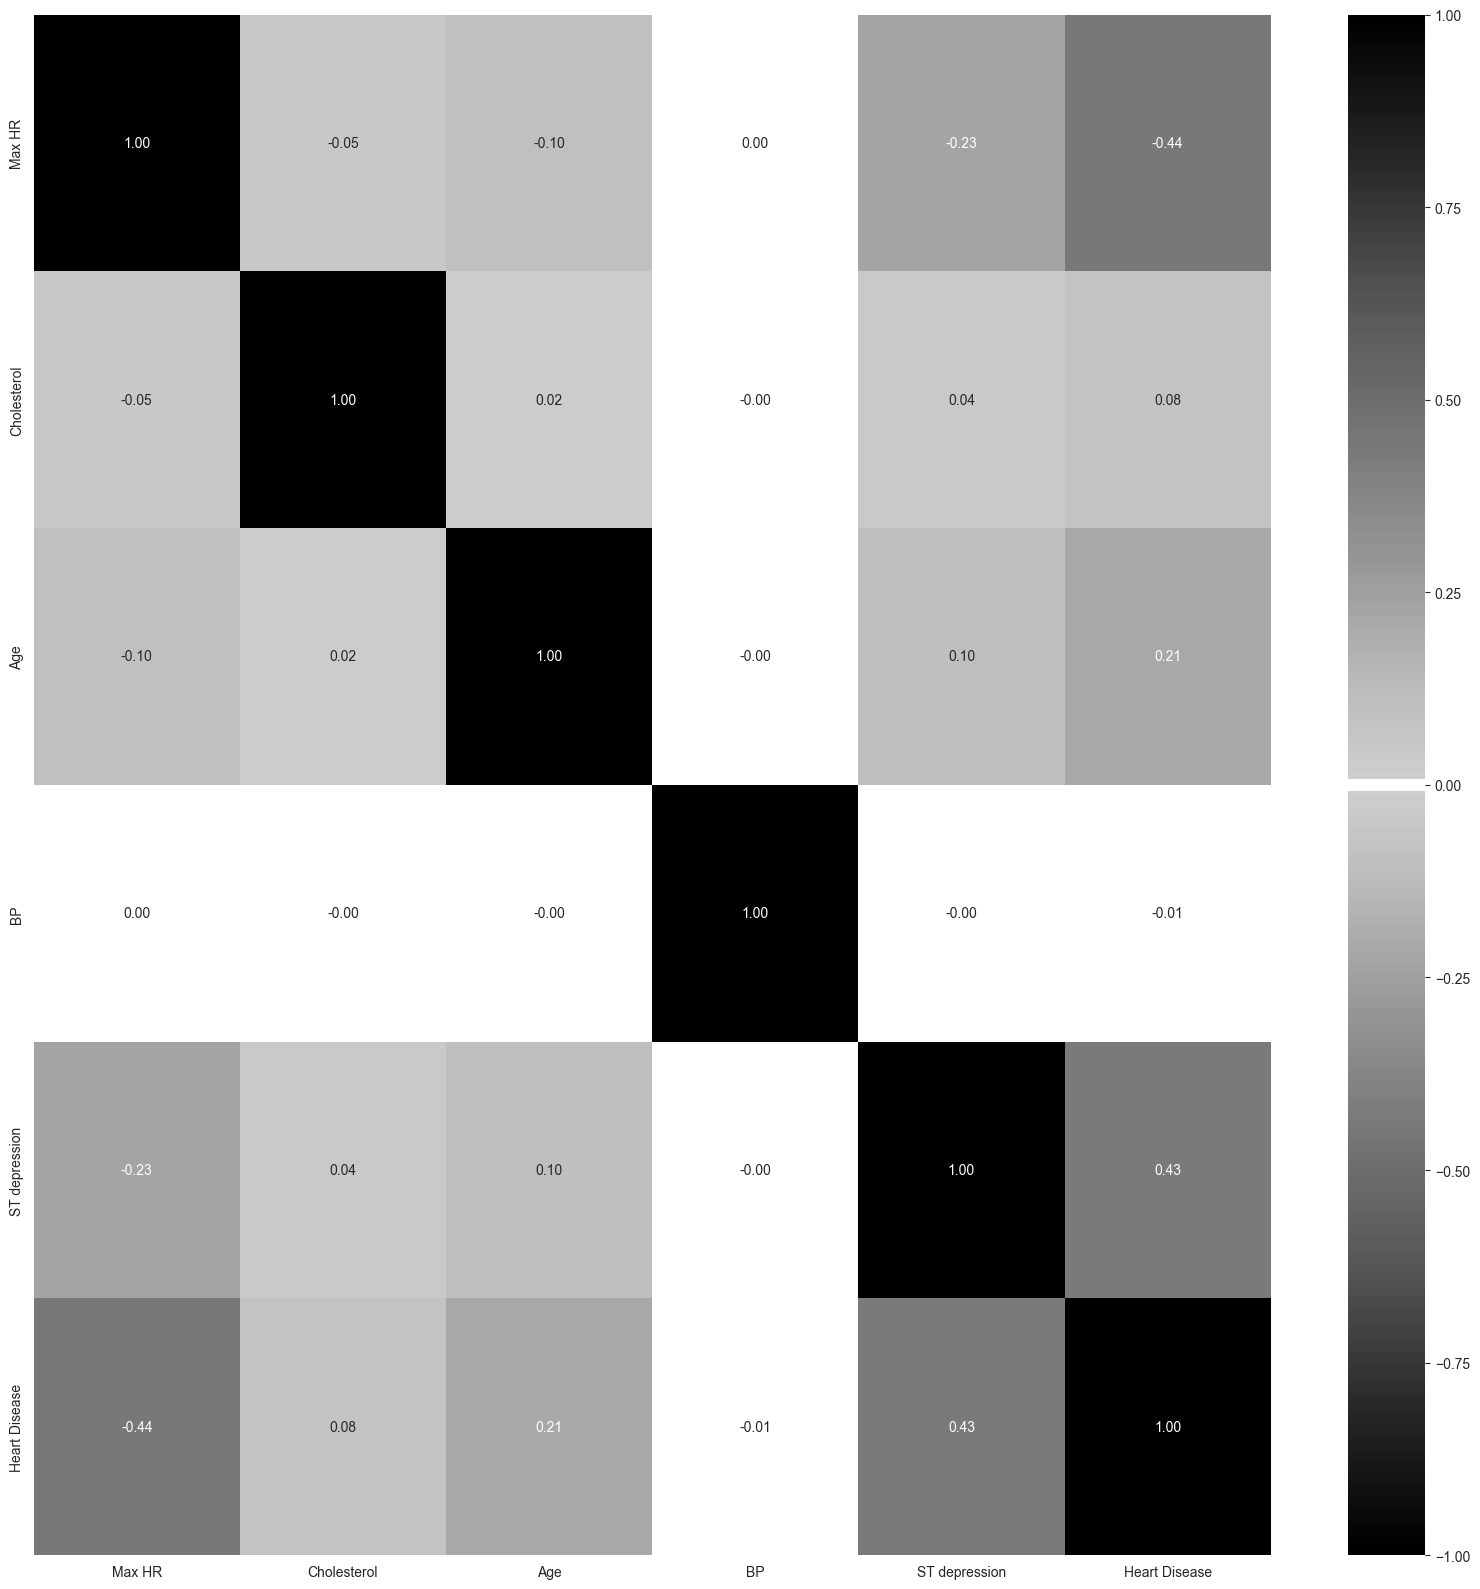

In [100]:
feature_list = numerical_features

correlation_data = feature_list.corr()

n_features = feature_list.shape[1]
n = feature_list.size/feature_list.shape[1]
custom_map.cmap_pearson(n_features, n , 0.1)
print(custom_map.cmap_pearson(n_features, n, 0.1))

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_data, annot=True, fmt=".2f", cmap="g-bajon", vmin=-1, vmax=1) #tab20b #h-bajon #g-bajon
plt.tight_layout()
plt.show()

{'name': 'g-bajon', 'alpha_eff': 0.002777777777777778, 'df': 629998.0, 't_crit': 2.991327923807529, 'r_crit': 0.003768698159316679, 'steps': 2, 'side_left': 127, 'side_right': 127, 'N': 630000.0}


/Users/dominikmika/PycharmProjects/Ridge-Hill-Climbing/src/custom_map.py:37: UserWarning: Overwriting the cmap 'g-bajon' that was already in the registry.
  mpl.colormaps.register(my_cmap, force=True)


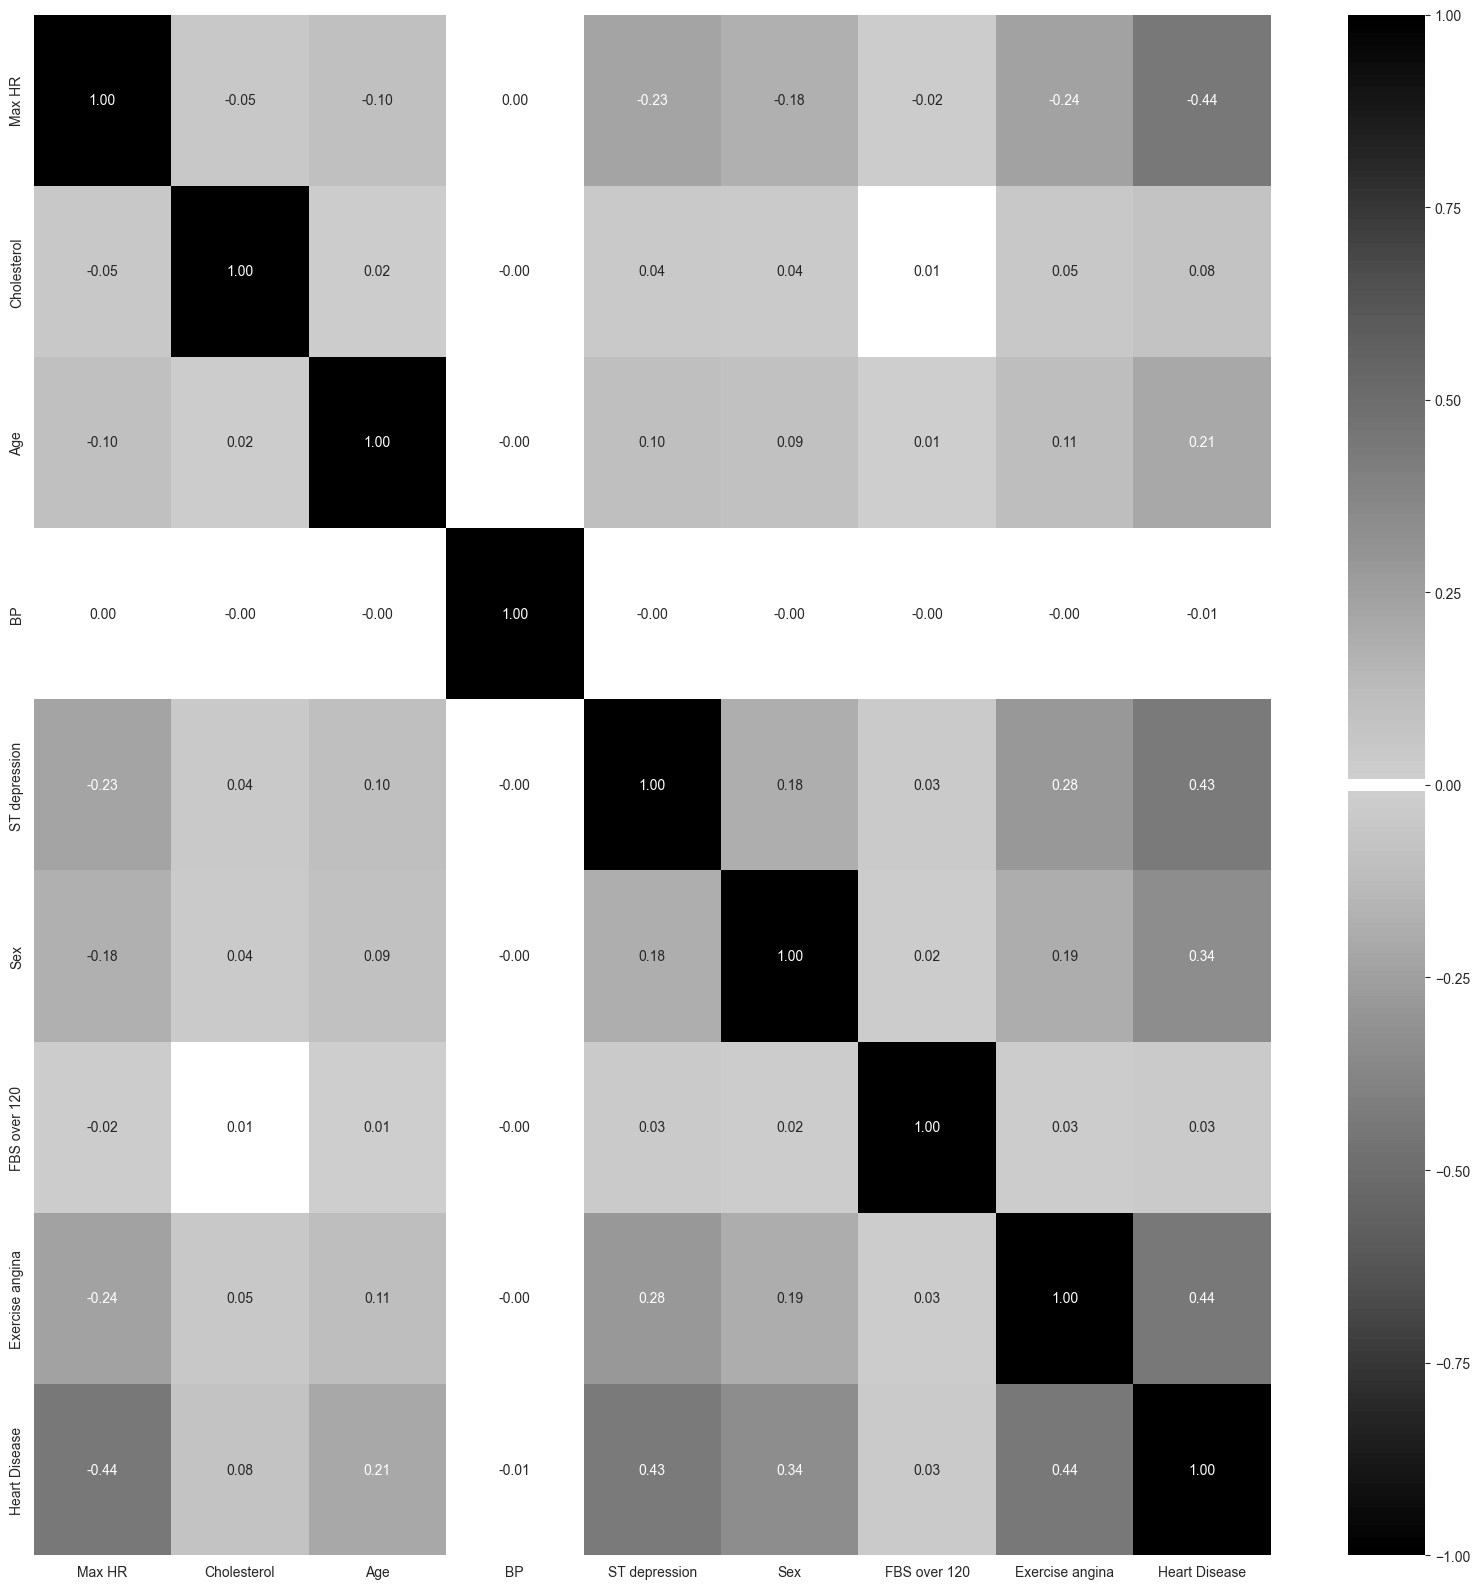

In [101]:
feature_list = numerical_binary_features

correlation_data = feature_list.corr()

n_features = feature_list.shape[1]
n = feature_list.size/feature_list.shape[1]
custom_map.cmap_pearson(n_features, n , 0.1)
print(custom_map.cmap_pearson(n_features, n, 0.1))

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_data, annot=True, fmt=".2f", cmap="g-bajon", vmin=-1, vmax=1) #tab20b #h-bajon #g-bajon
plt.tight_layout()
plt.show()